# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/ericness/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


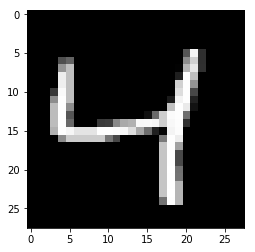

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [15]:
learning_rate = 0.001

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, strides=(2,2), pool_size=(2, 2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 =  tf.layers.max_pooling2d(conv2, strides=(2,2), pool_size=(2, 2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded =  tf.layers.max_pooling2d(conv2, strides=(2,2), pool_size=(2, 2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 =  tf.image.resize_nearest_neighbor(conv4, (14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 =  tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [16]:
sess = tf.Session()

In [17]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6828
Epoch: 1/20... Training loss: 0.6692
Epoch: 1/20... Training loss: 0.6546
Epoch: 1/20... Training loss: 0.6396
Epoch: 1/20... Training loss: 0.6224
Epoch: 1/20... Training loss: 0.6059
Epoch: 1/20... Training loss: 0.5899
Epoch: 1/20... Training loss: 0.5818
Epoch: 1/20... Training loss: 0.5629
Epoch: 1/20... Training loss: 0.5561
Epoch: 1/20... Training loss: 0.5537
Epoch: 1/20... Training loss: 0.5477
Epoch: 1/20... Training loss: 0.5419
Epoch: 1/20... Training loss: 0.5417
Epoch: 1/20... Training loss: 0.5223
Epoch: 1/20... Training loss: 0.5086
Epoch: 1/20... Training loss: 0.5095
Epoch: 1/20... Training loss: 0.4930
Epoch: 1/20... Training loss: 0.5029
Epoch: 1/20... Training loss: 0.4765
Epoch: 1/20... Training loss: 0.4727
Epoch: 1/20... Training loss: 0.4652
Epoch: 1/20... Training loss: 0.4649
Epoch: 1/20... Training loss: 0.4481
Epoch: 1/20... Training loss: 0.4409
Epoch: 1/20... Training loss: 0.4369
Epoch: 1/20... Training loss: 0.4260
E

Epoch: 1/20... Training loss: 0.1018
Epoch: 1/20... Training loss: 0.1025
Epoch: 1/20... Training loss: 0.1033
Epoch: 1/20... Training loss: 0.0977
Epoch: 1/20... Training loss: 0.0990
Epoch: 1/20... Training loss: 0.1015
Epoch: 1/20... Training loss: 0.0980
Epoch: 1/20... Training loss: 0.1017
Epoch: 1/20... Training loss: 0.0997
Epoch: 1/20... Training loss: 0.0988
Epoch: 1/20... Training loss: 0.0984
Epoch: 1/20... Training loss: 0.1025
Epoch: 1/20... Training loss: 0.0991
Epoch: 1/20... Training loss: 0.1005
Epoch: 1/20... Training loss: 0.1006
Epoch: 1/20... Training loss: 0.0985
Epoch: 1/20... Training loss: 0.1022
Epoch: 1/20... Training loss: 0.1010
Epoch: 1/20... Training loss: 0.1006
Epoch: 1/20... Training loss: 0.0966
Epoch: 1/20... Training loss: 0.0986
Epoch: 1/20... Training loss: 0.0944
Epoch: 1/20... Training loss: 0.1030
Epoch: 1/20... Training loss: 0.0982
Epoch: 1/20... Training loss: 0.0997
Epoch: 1/20... Training loss: 0.0968
Epoch: 1/20... Training loss: 0.0951
E

Epoch: 2/20... Training loss: 0.0865
Epoch: 2/20... Training loss: 0.0886
Epoch: 2/20... Training loss: 0.0889
Epoch: 2/20... Training loss: 0.0893
Epoch: 2/20... Training loss: 0.0853
Epoch: 2/20... Training loss: 0.0876
Epoch: 2/20... Training loss: 0.0859
Epoch: 2/20... Training loss: 0.0886
Epoch: 2/20... Training loss: 0.0871
Epoch: 2/20... Training loss: 0.0858
Epoch: 2/20... Training loss: 0.0881
Epoch: 2/20... Training loss: 0.0904
Epoch: 2/20... Training loss: 0.0873
Epoch: 2/20... Training loss: 0.0892
Epoch: 2/20... Training loss: 0.0851
Epoch: 2/20... Training loss: 0.0849
Epoch: 2/20... Training loss: 0.0861
Epoch: 2/20... Training loss: 0.0847
Epoch: 2/20... Training loss: 0.0868
Epoch: 2/20... Training loss: 0.0851
Epoch: 2/20... Training loss: 0.0893
Epoch: 2/20... Training loss: 0.0886
Epoch: 2/20... Training loss: 0.0894
Epoch: 2/20... Training loss: 0.0839
Epoch: 2/20... Training loss: 0.0836
Epoch: 2/20... Training loss: 0.0844
Epoch: 2/20... Training loss: 0.0885
E

Epoch: 3/20... Training loss: 0.0840
Epoch: 3/20... Training loss: 0.0831
Epoch: 3/20... Training loss: 0.0842
Epoch: 3/20... Training loss: 0.0834
Epoch: 3/20... Training loss: 0.0835
Epoch: 3/20... Training loss: 0.0833
Epoch: 3/20... Training loss: 0.0822
Epoch: 3/20... Training loss: 0.0840
Epoch: 3/20... Training loss: 0.0828
Epoch: 3/20... Training loss: 0.0842
Epoch: 3/20... Training loss: 0.0837
Epoch: 3/20... Training loss: 0.0833
Epoch: 3/20... Training loss: 0.0810
Epoch: 3/20... Training loss: 0.0861
Epoch: 3/20... Training loss: 0.0819
Epoch: 3/20... Training loss: 0.0872
Epoch: 3/20... Training loss: 0.0859
Epoch: 3/20... Training loss: 0.0825
Epoch: 3/20... Training loss: 0.0834
Epoch: 3/20... Training loss: 0.0851
Epoch: 3/20... Training loss: 0.0842
Epoch: 3/20... Training loss: 0.0831
Epoch: 3/20... Training loss: 0.0843
Epoch: 3/20... Training loss: 0.0833
Epoch: 3/20... Training loss: 0.0851
Epoch: 3/20... Training loss: 0.0826
Epoch: 3/20... Training loss: 0.0843
E

Epoch: 3/20... Training loss: 0.0796
Epoch: 3/20... Training loss: 0.0835
Epoch: 3/20... Training loss: 0.0808
Epoch: 3/20... Training loss: 0.0814
Epoch: 3/20... Training loss: 0.0797
Epoch: 3/20... Training loss: 0.0807
Epoch: 3/20... Training loss: 0.0811
Epoch: 3/20... Training loss: 0.0784
Epoch: 3/20... Training loss: 0.0781
Epoch: 3/20... Training loss: 0.0817
Epoch: 3/20... Training loss: 0.0807
Epoch: 3/20... Training loss: 0.0823
Epoch: 4/20... Training loss: 0.0789
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0838
Epoch: 4/20... Training loss: 0.0827
Epoch: 4/20... Training loss: 0.0799
Epoch: 4/20... Training loss: 0.0818
Epoch: 4/20... Training loss: 0.0808
Epoch: 4/20... Training loss: 0.0804
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0769
Epoch: 4/20... Training loss: 0.0803
Epoch: 4/20... Training loss: 0.0787
Epoch: 4/20... Training loss: 0.0824
E

Epoch: 4/20... Training loss: 0.0786
Epoch: 4/20... Training loss: 0.0784
Epoch: 4/20... Training loss: 0.0809
Epoch: 4/20... Training loss: 0.0783
Epoch: 4/20... Training loss: 0.0806
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0787
Epoch: 4/20... Training loss: 0.0792
Epoch: 4/20... Training loss: 0.0801
Epoch: 4/20... Training loss: 0.0795
Epoch: 4/20... Training loss: 0.0777
Epoch: 4/20... Training loss: 0.0795
Epoch: 4/20... Training loss: 0.0801
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0782
Epoch: 4/20... Training loss: 0.0775
Epoch: 4/20... Training loss: 0.0740
Epoch: 4/20... Training loss: 0.0792
Epoch: 4/20... Training loss: 0.0795
Epoch: 4/20... Training loss: 0.0775
Epoch: 4/20... Training loss: 0.0799
Epoch: 4/20... Training loss: 0.0817
Epoch: 4/20... Training loss: 0.0768
Epoch: 4/20... Training loss: 0.0778
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0790
Epoch: 4/20... Training loss: 0.0804
E

Epoch: 5/20... Training loss: 0.0783
Epoch: 5/20... Training loss: 0.0767
Epoch: 5/20... Training loss: 0.0772
Epoch: 5/20... Training loss: 0.0790
Epoch: 5/20... Training loss: 0.0804
Epoch: 5/20... Training loss: 0.0819
Epoch: 5/20... Training loss: 0.0768
Epoch: 5/20... Training loss: 0.0782
Epoch: 5/20... Training loss: 0.0787
Epoch: 5/20... Training loss: 0.0775
Epoch: 5/20... Training loss: 0.0780
Epoch: 5/20... Training loss: 0.0798
Epoch: 5/20... Training loss: 0.0745
Epoch: 5/20... Training loss: 0.0805
Epoch: 5/20... Training loss: 0.0800
Epoch: 5/20... Training loss: 0.0769
Epoch: 5/20... Training loss: 0.0769
Epoch: 5/20... Training loss: 0.0782
Epoch: 5/20... Training loss: 0.0747
Epoch: 5/20... Training loss: 0.0766
Epoch: 5/20... Training loss: 0.0797
Epoch: 5/20... Training loss: 0.0792
Epoch: 5/20... Training loss: 0.0760
Epoch: 5/20... Training loss: 0.0803
Epoch: 5/20... Training loss: 0.0783
Epoch: 5/20... Training loss: 0.0777
Epoch: 5/20... Training loss: 0.0789
E

Epoch: 6/20... Training loss: 0.0776
Epoch: 6/20... Training loss: 0.0758
Epoch: 6/20... Training loss: 0.0745
Epoch: 6/20... Training loss: 0.0782
Epoch: 6/20... Training loss: 0.0751
Epoch: 6/20... Training loss: 0.0761
Epoch: 6/20... Training loss: 0.0735
Epoch: 6/20... Training loss: 0.0788
Epoch: 6/20... Training loss: 0.0787
Epoch: 6/20... Training loss: 0.0784
Epoch: 6/20... Training loss: 0.0770
Epoch: 6/20... Training loss: 0.0781
Epoch: 6/20... Training loss: 0.0764
Epoch: 6/20... Training loss: 0.0763
Epoch: 6/20... Training loss: 0.0763
Epoch: 6/20... Training loss: 0.0747
Epoch: 6/20... Training loss: 0.0761
Epoch: 6/20... Training loss: 0.0766
Epoch: 6/20... Training loss: 0.0781
Epoch: 6/20... Training loss: 0.0776
Epoch: 6/20... Training loss: 0.0761
Epoch: 6/20... Training loss: 0.0776
Epoch: 6/20... Training loss: 0.0752
Epoch: 6/20... Training loss: 0.0772
Epoch: 6/20... Training loss: 0.0765
Epoch: 6/20... Training loss: 0.0774
Epoch: 6/20... Training loss: 0.0767
E

Epoch: 6/20... Training loss: 0.0752
Epoch: 6/20... Training loss: 0.0771
Epoch: 6/20... Training loss: 0.0761
Epoch: 6/20... Training loss: 0.0757
Epoch: 6/20... Training loss: 0.0735
Epoch: 6/20... Training loss: 0.0742
Epoch: 6/20... Training loss: 0.0775
Epoch: 6/20... Training loss: 0.0763
Epoch: 6/20... Training loss: 0.0758
Epoch: 6/20... Training loss: 0.0773
Epoch: 6/20... Training loss: 0.0772
Epoch: 6/20... Training loss: 0.0766
Epoch: 6/20... Training loss: 0.0770
Epoch: 6/20... Training loss: 0.0737
Epoch: 6/20... Training loss: 0.0748
Epoch: 6/20... Training loss: 0.0752
Epoch: 6/20... Training loss: 0.0755
Epoch: 6/20... Training loss: 0.0753
Epoch: 6/20... Training loss: 0.0770
Epoch: 6/20... Training loss: 0.0760
Epoch: 6/20... Training loss: 0.0777
Epoch: 6/20... Training loss: 0.0767
Epoch: 6/20... Training loss: 0.0750
Epoch: 6/20... Training loss: 0.0754
Epoch: 7/20... Training loss: 0.0769
Epoch: 7/20... Training loss: 0.0766
Epoch: 7/20... Training loss: 0.0759
E

Epoch: 7/20... Training loss: 0.0762
Epoch: 7/20... Training loss: 0.0740
Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0755
Epoch: 7/20... Training loss: 0.0768
Epoch: 7/20... Training loss: 0.0764
Epoch: 7/20... Training loss: 0.0746
Epoch: 7/20... Training loss: 0.0750
Epoch: 7/20... Training loss: 0.0755
Epoch: 7/20... Training loss: 0.0739
Epoch: 7/20... Training loss: 0.0750
Epoch: 7/20... Training loss: 0.0748
Epoch: 7/20... Training loss: 0.0753
Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0749
Epoch: 7/20... Training loss: 0.0766
Epoch: 7/20... Training loss: 0.0774
Epoch: 7/20... Training loss: 0.0747
Epoch: 7/20... Training loss: 0.0765
Epoch: 7/20... Training loss: 0.0773
Epoch: 7/20... Training loss: 0.0754
Epoch: 7/20... Training loss: 0.0753
Epoch: 7/20... Training loss: 0.0751
Epoch: 7/20... Training loss: 0.0750
Epoch: 7/20... Training loss: 0.0755
Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0770
E

Epoch: 8/20... Training loss: 0.0774
Epoch: 8/20... Training loss: 0.0761
Epoch: 8/20... Training loss: 0.0746
Epoch: 8/20... Training loss: 0.0738
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0771
Epoch: 8/20... Training loss: 0.0755
Epoch: 8/20... Training loss: 0.0745
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0751
Epoch: 8/20... Training loss: 0.0789
Epoch: 8/20... Training loss: 0.0728
Epoch: 8/20... Training loss: 0.0738
Epoch: 8/20... Training loss: 0.0725
Epoch: 8/20... Training loss: 0.0748
Epoch: 8/20... Training loss: 0.0744
Epoch: 8/20... Training loss: 0.0769
Epoch: 8/20... Training loss: 0.0732
Epoch: 8/20... Training loss: 0.0755
Epoch: 8/20... Training loss: 0.0739
Epoch: 8/20... Training loss: 0.0753
Epoch: 8/20... Training loss: 0.0750
Epoch: 8/20... Training loss: 0.0732
Epoch: 8/20... Training loss: 0.0747
Epoch: 8/20... Training loss: 0.0744
Epoch: 8/20... Training loss: 0.0755
Epoch: 8/20... Training loss: 0.0732
E

Epoch: 9/20... Training loss: 0.0739
Epoch: 9/20... Training loss: 0.0744
Epoch: 9/20... Training loss: 0.0736
Epoch: 9/20... Training loss: 0.0764
Epoch: 9/20... Training loss: 0.0747
Epoch: 9/20... Training loss: 0.0724
Epoch: 9/20... Training loss: 0.0751
Epoch: 9/20... Training loss: 0.0726
Epoch: 9/20... Training loss: 0.0727
Epoch: 9/20... Training loss: 0.0774
Epoch: 9/20... Training loss: 0.0745
Epoch: 9/20... Training loss: 0.0731
Epoch: 9/20... Training loss: 0.0750
Epoch: 9/20... Training loss: 0.0721
Epoch: 9/20... Training loss: 0.0740
Epoch: 9/20... Training loss: 0.0740
Epoch: 9/20... Training loss: 0.0744
Epoch: 9/20... Training loss: 0.0739
Epoch: 9/20... Training loss: 0.0747
Epoch: 9/20... Training loss: 0.0739
Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0748
Epoch: 9/20... Training loss: 0.0725
Epoch: 9/20... Training loss: 0.0750
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0755
Epoch: 9/20... Training loss: 0.0742
E

Epoch: 9/20... Training loss: 0.0752
Epoch: 9/20... Training loss: 0.0754
Epoch: 9/20... Training loss: 0.0758
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0722
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0729
Epoch: 9/20... Training loss: 0.0725
Epoch: 9/20... Training loss: 0.0739
Epoch: 9/20... Training loss: 0.0740
Epoch: 9/20... Training loss: 0.0753
Epoch: 9/20... Training loss: 0.0740
Epoch: 9/20... Training loss: 0.0724
Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0737
Epoch: 9/20... Training loss: 0.0749
Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0723
Epoch: 9/20... Training loss: 0.0743
Epoch: 9/20... Training loss: 0.0745
Epoch: 9/20... Training loss: 0.0741
Epoch: 9/20... Training loss: 0.0717
Epoch: 9/20... Training loss: 0.0763
Epoch: 9/20... Training loss: 0.0716
Epoch: 9/20... Training loss: 0.0744
Epoch: 9/20... Training loss: 0.0745
Epoch: 9/20... Training loss: 0.0737
E

Epoch: 10/20... Training loss: 0.0730
Epoch: 10/20... Training loss: 0.0742
Epoch: 10/20... Training loss: 0.0722
Epoch: 10/20... Training loss: 0.0720
Epoch: 10/20... Training loss: 0.0749
Epoch: 10/20... Training loss: 0.0739
Epoch: 10/20... Training loss: 0.0751
Epoch: 10/20... Training loss: 0.0750
Epoch: 10/20... Training loss: 0.0747
Epoch: 10/20... Training loss: 0.0717
Epoch: 10/20... Training loss: 0.0715
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0739
Epoch: 10/20... Training loss: 0.0739
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0715
Epoch: 10/20... Training loss: 0.0729
Epoch: 10/20... Training loss: 0.0743
Epoch: 10/20... Training loss: 0.0754
Epoch: 10/20... Training loss: 0.0748
Epoch: 10/20... Training loss: 0.0738
Epoch: 10/20... Training loss: 0.0744
Epoch: 10/20... Training loss: 0.0727
Epoch: 10/20... Training loss: 0.0728
Epoch: 10/20... Training loss: 0.0753
Epoch: 10/20... Training loss: 0.0753
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0749
Epoch: 11/20... Training loss: 0.0722
Epoch: 11/20... Training loss: 0.0732
Epoch: 11/20... Training loss: 0.0741
Epoch: 11/20... Training loss: 0.0735
Epoch: 11/20... Training loss: 0.0751
Epoch: 11/20... Training loss: 0.0705
Epoch: 11/20... Training loss: 0.0727
Epoch: 11/20... Training loss: 0.0735
Epoch: 11/20... Training loss: 0.0741
Epoch: 11/20... Training loss: 0.0743
Epoch: 11/20... Training loss: 0.0732
Epoch: 11/20... Training loss: 0.0714
Epoch: 11/20... Training loss: 0.0728
Epoch: 11/20... Training loss: 0.0730
Epoch: 11/20... Training loss: 0.0727
Epoch: 11/20... Training loss: 0.0729
Epoch: 11/20... Training loss: 0.0736
Epoch: 11/20... Training loss: 0.0720
Epoch: 11/20... Training loss: 0.0726
Epoch: 11/20... Training loss: 0.0743
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0719
Epoch: 11/20... Training loss: 0.0730
Epoch: 11/20... Training loss: 0.0706
Epoch: 11/20... Training loss: 0.0732
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0728
Epoch: 12/20... Training loss: 0.0745
Epoch: 12/20... Training loss: 0.0721
Epoch: 12/20... Training loss: 0.0750
Epoch: 12/20... Training loss: 0.0719
Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20... Training loss: 0.0707
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0731
Epoch: 12/20... Training loss: 0.0733
Epoch: 12/20... Training loss: 0.0737
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0708
Epoch: 12/20... Training loss: 0.0726
Epoch: 12/20... Training loss: 0.0734
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0723
Epoch: 12/20... Training loss: 0.0723
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0739
Epoch: 12/20... Training loss: 0.0698
Epoch: 12/20... Training loss: 0.0739
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0702
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0736
Epoch: 12/20... Training loss: 0.0709
Epoch: 12/20... Training loss: 0.0720
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0718
Epoch: 12/20... Training loss: 0.0762
Epoch: 12/20... Training loss: 0.0720
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0734
Epoch: 12/20... Training loss: 0.0720
Epoch: 12/20... Training loss: 0.0734
Epoch: 12/20... Training loss: 0.0728
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0710
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0723
Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20... Training loss: 0.0715
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0722
Epoch: 12/20... Training loss: 0.0733
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0725
Epoch: 12/20... Training loss: 0.0739
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0720
Epoch: 13/20... Training loss: 0.0717
Epoch: 13/20... Training loss: 0.0685
Epoch: 13/20... Training loss: 0.0734
Epoch: 13/20... Training loss: 0.0724
Epoch: 13/20... Training loss: 0.0723
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0729
Epoch: 13/20... Training loss: 0.0748
Epoch: 13/20... Training loss: 0.0728
Epoch: 13/20... Training loss: 0.0723
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0734
Epoch: 13/20... Training loss: 0.0713
Epoch: 13/20... Training loss: 0.0714
Epoch: 13/20... Training loss: 0.0734
Epoch: 13/20... Training loss: 0.0718
Epoch: 13/20... Training loss: 0.0734
Epoch: 13/20... Training loss: 0.0704
Epoch: 13/20... Training loss: 0.0735
Epoch: 13/20... Training loss: 0.0736
Epoch: 13/20... Training loss: 0.0734
Epoch: 13/20... Training loss: 0.0711
Epoch: 13/20... Training loss: 0.0717
Epoch: 13/20... Training loss: 0.0735
Epoch: 13/20... Training loss: 0.0739
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0734
Epoch: 14/20... Training loss: 0.0720
Epoch: 14/20... Training loss: 0.0730
Epoch: 14/20... Training loss: 0.0722
Epoch: 14/20... Training loss: 0.0717
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20... Training loss: 0.0743
Epoch: 14/20... Training loss: 0.0704
Epoch: 14/20... Training loss: 0.0717
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20... Training loss: 0.0702
Epoch: 14/20... Training loss: 0.0716
Epoch: 14/20... Training loss: 0.0707
Epoch: 14/20... Training loss: 0.0706
Epoch: 14/20... Training loss: 0.0752
Epoch: 14/20... Training loss: 0.0709
Epoch: 14/20... Training loss: 0.0725
Epoch: 14/20... Training loss: 0.0736
Epoch: 14/20... Training loss: 0.0719
Epoch: 14/20... Training loss: 0.0725
Epoch: 14/20... Training loss: 0.0723
Epoch: 14/20... Training loss: 0.0703
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20... Training loss: 0.0719
Epoch: 14/20... Training loss: 0.0725
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20

Epoch: 14/20... Training loss: 0.0707
Epoch: 14/20... Training loss: 0.0724
Epoch: 14/20... Training loss: 0.0704
Epoch: 14/20... Training loss: 0.0709
Epoch: 14/20... Training loss: 0.0736
Epoch: 14/20... Training loss: 0.0725
Epoch: 14/20... Training loss: 0.0751
Epoch: 14/20... Training loss: 0.0713
Epoch: 14/20... Training loss: 0.0695
Epoch: 14/20... Training loss: 0.0711
Epoch: 14/20... Training loss: 0.0717
Epoch: 14/20... Training loss: 0.0719
Epoch: 14/20... Training loss: 0.0711
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0725
Epoch: 14/20... Training loss: 0.0718
Epoch: 14/20... Training loss: 0.0724
Epoch: 14/20... Training loss: 0.0704
Epoch: 14/20... Training loss: 0.0722
Epoch: 14/20... Training loss: 0.0733
Epoch: 14/20... Training loss: 0.0720
Epoch: 14/20... Training loss: 0.0750
Epoch: 14/20... Training loss: 0.0736
Epoch: 15/20... Training loss: 0.0701
Epoch: 15/20... Training loss: 0.0746
Epoch: 15/20... Training loss: 0.0707
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0724
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0716
Epoch: 15/20... Training loss: 0.0732
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0726
Epoch: 15/20... Training loss: 0.0720
Epoch: 15/20... Training loss: 0.0719
Epoch: 15/20... Training loss: 0.0722
Epoch: 15/20... Training loss: 0.0722
Epoch: 15/20... Training loss: 0.0740
Epoch: 15/20... Training loss: 0.0711
Epoch: 15/20... Training loss: 0.0720
Epoch: 15/20... Training loss: 0.0724
Epoch: 15/20... Training loss: 0.0706
Epoch: 15/20... Training loss: 0.0706
Epoch: 15/20... Training loss: 0.0706
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0707
Epoch: 15/20... Training loss: 0.0710
Epoch: 15/20... Training loss: 0.0733
Epoch: 15/20... Training loss: 0.0696
Epoch: 15/20... Training loss: 0.0709
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0717
Epoch: 16/20... Training loss: 0.0718
Epoch: 16/20... Training loss: 0.0718
Epoch: 16/20... Training loss: 0.0701
Epoch: 16/20... Training loss: 0.0711
Epoch: 16/20... Training loss: 0.0720
Epoch: 16/20... Training loss: 0.0727
Epoch: 16/20... Training loss: 0.0729
Epoch: 16/20... Training loss: 0.0701
Epoch: 16/20... Training loss: 0.0722
Epoch: 16/20... Training loss: 0.0703
Epoch: 16/20... Training loss: 0.0735
Epoch: 16/20... Training loss: 0.0723
Epoch: 16/20... Training loss: 0.0755
Epoch: 16/20... Training loss: 0.0710
Epoch: 16/20... Training loss: 0.0722
Epoch: 16/20... Training loss: 0.0718
Epoch: 16/20... Training loss: 0.0705
Epoch: 16/20... Training loss: 0.0704
Epoch: 16/20... Training loss: 0.0719
Epoch: 16/20... Training loss: 0.0714
Epoch: 16/20... Training loss: 0.0718
Epoch: 16/20... Training loss: 0.0706
Epoch: 16/20... Training loss: 0.0710
Epoch: 16/20... Training loss: 0.0705
Epoch: 16/20... Training loss: 0.0728
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0701
Epoch: 17/20... Training loss: 0.0688
Epoch: 17/20... Training loss: 0.0684
Epoch: 17/20... Training loss: 0.0724
Epoch: 17/20... Training loss: 0.0702
Epoch: 17/20... Training loss: 0.0712
Epoch: 17/20... Training loss: 0.0720
Epoch: 17/20... Training loss: 0.0698
Epoch: 17/20... Training loss: 0.0723
Epoch: 17/20... Training loss: 0.0715
Epoch: 17/20... Training loss: 0.0712
Epoch: 17/20... Training loss: 0.0715
Epoch: 17/20... Training loss: 0.0712
Epoch: 17/20... Training loss: 0.0720
Epoch: 17/20... Training loss: 0.0713
Epoch: 17/20... Training loss: 0.0704
Epoch: 17/20... Training loss: 0.0692
Epoch: 17/20... Training loss: 0.0728
Epoch: 17/20... Training loss: 0.0715
Epoch: 17/20... Training loss: 0.0704
Epoch: 17/20... Training loss: 0.0710
Epoch: 17/20... Training loss: 0.0697
Epoch: 17/20... Training loss: 0.0732
Epoch: 17/20... Training loss: 0.0704
Epoch: 17/20... Training loss: 0.0717
Epoch: 17/20... Training loss: 0.0719
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0710
Epoch: 17/20... Training loss: 0.0699
Epoch: 17/20... Training loss: 0.0728
Epoch: 17/20... Training loss: 0.0712
Epoch: 17/20... Training loss: 0.0704
Epoch: 17/20... Training loss: 0.0702
Epoch: 17/20... Training loss: 0.0716
Epoch: 17/20... Training loss: 0.0708
Epoch: 17/20... Training loss: 0.0714
Epoch: 17/20... Training loss: 0.0724
Epoch: 17/20... Training loss: 0.0737
Epoch: 17/20... Training loss: 0.0713
Epoch: 17/20... Training loss: 0.0719
Epoch: 17/20... Training loss: 0.0705
Epoch: 17/20... Training loss: 0.0714
Epoch: 17/20... Training loss: 0.0707
Epoch: 17/20... Training loss: 0.0705
Epoch: 17/20... Training loss: 0.0709
Epoch: 17/20... Training loss: 0.0703
Epoch: 17/20... Training loss: 0.0729
Epoch: 17/20... Training loss: 0.0721
Epoch: 17/20... Training loss: 0.0704
Epoch: 17/20... Training loss: 0.0703
Epoch: 17/20... Training loss: 0.0703
Epoch: 17/20... Training loss: 0.0708
Epoch: 17/20... Training loss: 0.0710
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0712
Epoch: 18/20... Training loss: 0.0719
Epoch: 18/20... Training loss: 0.0717
Epoch: 18/20... Training loss: 0.0719
Epoch: 18/20... Training loss: 0.0696
Epoch: 18/20... Training loss: 0.0711
Epoch: 18/20... Training loss: 0.0703
Epoch: 18/20... Training loss: 0.0710
Epoch: 18/20... Training loss: 0.0716
Epoch: 18/20... Training loss: 0.0708
Epoch: 18/20... Training loss: 0.0711
Epoch: 18/20... Training loss: 0.0705
Epoch: 18/20... Training loss: 0.0694
Epoch: 18/20... Training loss: 0.0691
Epoch: 18/20... Training loss: 0.0730
Epoch: 18/20... Training loss: 0.0705
Epoch: 18/20... Training loss: 0.0709
Epoch: 18/20... Training loss: 0.0700
Epoch: 18/20... Training loss: 0.0701
Epoch: 18/20... Training loss: 0.0731
Epoch: 18/20... Training loss: 0.0684
Epoch: 18/20... Training loss: 0.0683
Epoch: 18/20... Training loss: 0.0687
Epoch: 18/20... Training loss: 0.0719
Epoch: 18/20... Training loss: 0.0703
Epoch: 18/20... Training loss: 0.0714
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0708
Epoch: 19/20... Training loss: 0.0718
Epoch: 19/20... Training loss: 0.0721
Epoch: 19/20... Training loss: 0.0705
Epoch: 19/20... Training loss: 0.0714
Epoch: 19/20... Training loss: 0.0698
Epoch: 19/20... Training loss: 0.0689
Epoch: 19/20... Training loss: 0.0712
Epoch: 19/20... Training loss: 0.0718
Epoch: 19/20... Training loss: 0.0704
Epoch: 19/20... Training loss: 0.0695
Epoch: 19/20... Training loss: 0.0708
Epoch: 19/20... Training loss: 0.0705
Epoch: 19/20... Training loss: 0.0690
Epoch: 19/20... Training loss: 0.0727
Epoch: 19/20... Training loss: 0.0666
Epoch: 19/20... Training loss: 0.0723
Epoch: 19/20... Training loss: 0.0719
Epoch: 19/20... Training loss: 0.0700
Epoch: 19/20... Training loss: 0.0723
Epoch: 19/20... Training loss: 0.0713
Epoch: 19/20... Training loss: 0.0709
Epoch: 19/20... Training loss: 0.0691
Epoch: 19/20... Training loss: 0.0698
Epoch: 19/20... Training loss: 0.0689
Epoch: 19/20... Training loss: 0.0704
Epoch: 19/20

Epoch: 19/20... Training loss: 0.0696
Epoch: 19/20... Training loss: 0.0717
Epoch: 19/20... Training loss: 0.0716
Epoch: 19/20... Training loss: 0.0717
Epoch: 19/20... Training loss: 0.0707
Epoch: 19/20... Training loss: 0.0698
Epoch: 19/20... Training loss: 0.0699
Epoch: 19/20... Training loss: 0.0716
Epoch: 19/20... Training loss: 0.0716
Epoch: 19/20... Training loss: 0.0715
Epoch: 19/20... Training loss: 0.0700
Epoch: 20/20... Training loss: 0.0724
Epoch: 20/20... Training loss: 0.0700
Epoch: 20/20... Training loss: 0.0683
Epoch: 20/20... Training loss: 0.0710
Epoch: 20/20... Training loss: 0.0720
Epoch: 20/20... Training loss: 0.0696
Epoch: 20/20... Training loss: 0.0708
Epoch: 20/20... Training loss: 0.0708
Epoch: 20/20... Training loss: 0.0700
Epoch: 20/20... Training loss: 0.0679
Epoch: 20/20... Training loss: 0.0707
Epoch: 20/20... Training loss: 0.0693
Epoch: 20/20... Training loss: 0.0742
Epoch: 20/20... Training loss: 0.0695
Epoch: 20/20... Training loss: 0.0704
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0685
Epoch: 20/20... Training loss: 0.0707
Epoch: 20/20... Training loss: 0.0718
Epoch: 20/20... Training loss: 0.0712
Epoch: 20/20... Training loss: 0.0701
Epoch: 20/20... Training loss: 0.0683
Epoch: 20/20... Training loss: 0.0702
Epoch: 20/20... Training loss: 0.0696
Epoch: 20/20... Training loss: 0.0706
Epoch: 20/20... Training loss: 0.0691
Epoch: 20/20... Training loss: 0.0714
Epoch: 20/20... Training loss: 0.0694
Epoch: 20/20... Training loss: 0.0706
Epoch: 20/20... Training loss: 0.0721
Epoch: 20/20... Training loss: 0.0710
Epoch: 20/20... Training loss: 0.0682
Epoch: 20/20... Training loss: 0.0715
Epoch: 20/20... Training loss: 0.0698
Epoch: 20/20... Training loss: 0.0667
Epoch: 20/20... Training loss: 0.0699
Epoch: 20/20... Training loss: 0.0700
Epoch: 20/20... Training loss: 0.0705
Epoch: 20/20... Training loss: 0.0708
Epoch: 20/20... Training loss: 0.0707
Epoch: 20/20... Training loss: 0.0713
Epoch: 20/20... Training loss: 0.0719
Epoch: 20/20

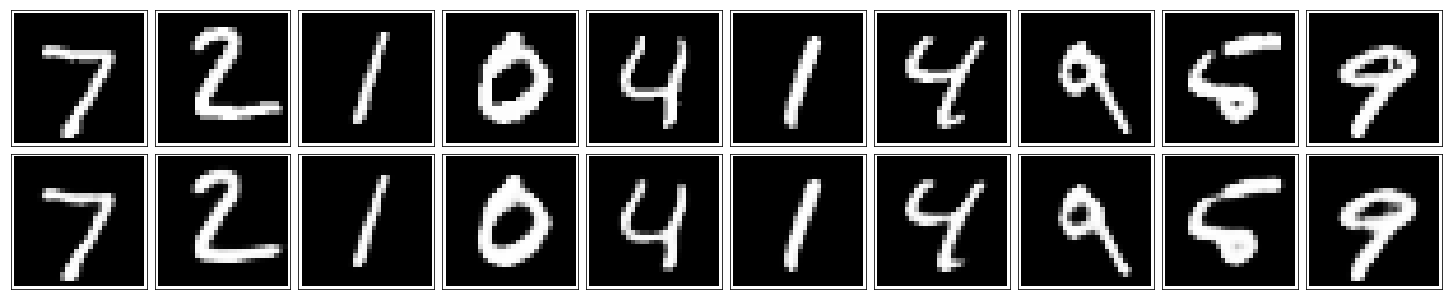

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = 
# Now 28x28x32
maxpool1 = 
# Now 14x14x32
conv2 = 
# Now 14x14x32
maxpool2 = 
# Now 7x7x32
conv3 = 
# Now 7x7x16
encoded = 
# Now 4x4x16

### Decoder
upsample1 = 
# Now 7x7x16
conv4 = 
# Now 7x7x16
upsample2 = 
# Now 14x14x16
conv5 = 
# Now 14x14x32
upsample3 = 
# Now 28x28x32
conv6 = 
# Now 28x28x32

logits = 
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = 

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

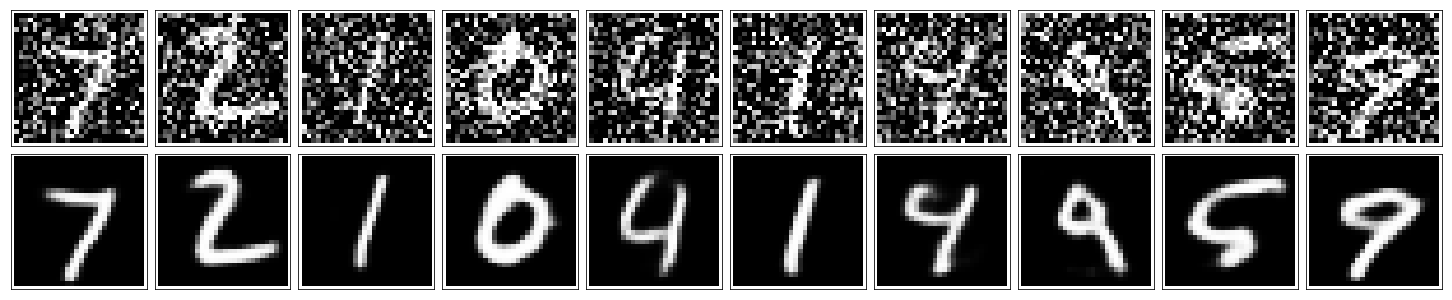

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)